In [1]:
import os
import json
import base64

import time
import requests
import selenium

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from tqdm.notebook import tqdm
from importlib.metadata import version
from IPython.display import display, Image

In [2]:
import platform

current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

print(f"selenium version : {version('selenium')}")
print(f"requests version : {version('requests')}")
print(f"tqdm version : {version('tqdm')}")
print(f"IPython version : {version('IPython')}")

Current OS: Darwin
Python Version: 3.9.13
selenium version : 4.19.0
requests version : 2.28.1
tqdm version : 4.64.1
IPython version : 7.31.1


In [3]:
def create_folders(data_dir, source_name, keyword):
    '''
    이미지를 저장할 폴더를 생성하는 함수
    Args:
        data_dir (str): 이미지를 저장할 폴더의 상위 경로
        source_name (str): 이미지를 수집한 사이트의 이름
        keyword (str): 이미지를 수집한 키워드
    '''
    # exist_ok=True : 폴더가 이미 존재할 경우 더 이상 에러를 발생시키지 않고 넘어갑니다.
    os.makedirs(os.path.join(data_dir, keyword), exist_ok=True)
    os.makedirs(os.path.join(data_dir, keyword, source_name), exist_ok=True)

In [4]:
def setup_webdriver():
    '''
    크롤링에 필요한 웹드라이버를 설정하는 함수
    Returns:
        driver (WebDriver): 크롬 웹드라이버
    '''
    # colab에서 사용할 경우
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)

    # # 로컬에서 사용할 경우
    # # 위의 colab 관련 코드를 주석처리하고 아래의 코드를 주석해제해주세요.
    # # driver_path에 미리 다운로드 받은 크롬드라이버의 경로를 입력해주세요.
    # driver_path = '/Users/USER/Downloads/chromedriver'
    # driver = webdriver.Chrome(driver_path)

    return driver

In [5]:
def access_google_image_search(driver, keyword):
    '''
    구글 이미지 검색창에 접속하는 함수
    Args:
        driver (WebDriver): 크롬 웹드라이버
        keyword (str): 이미지를 수집할 키워드
    '''
    # 구글 이미지 검색창 접속하기
    driver.get(f'https://www.google.com/imghp')
    time.sleep(3) # 이미지 검색창이 로딩될 때까지 3초 기다립니다.
    print('이미지 검색창 접속 완료')

    # 구글 이미지 검색창에 키워드를 입력합니다.
    element = driver.find_element(By.NAME,"q")
    element.send_keys(keyword)
    element.send_keys(Keys.RETURN)
    time.sleep(3) # 이미지 검색결과가 로딩될 때까지 3초 기다립니다.
    print('검색어 입력 완료')

이미지 검색창 접속 완료
검색어 입력 완료


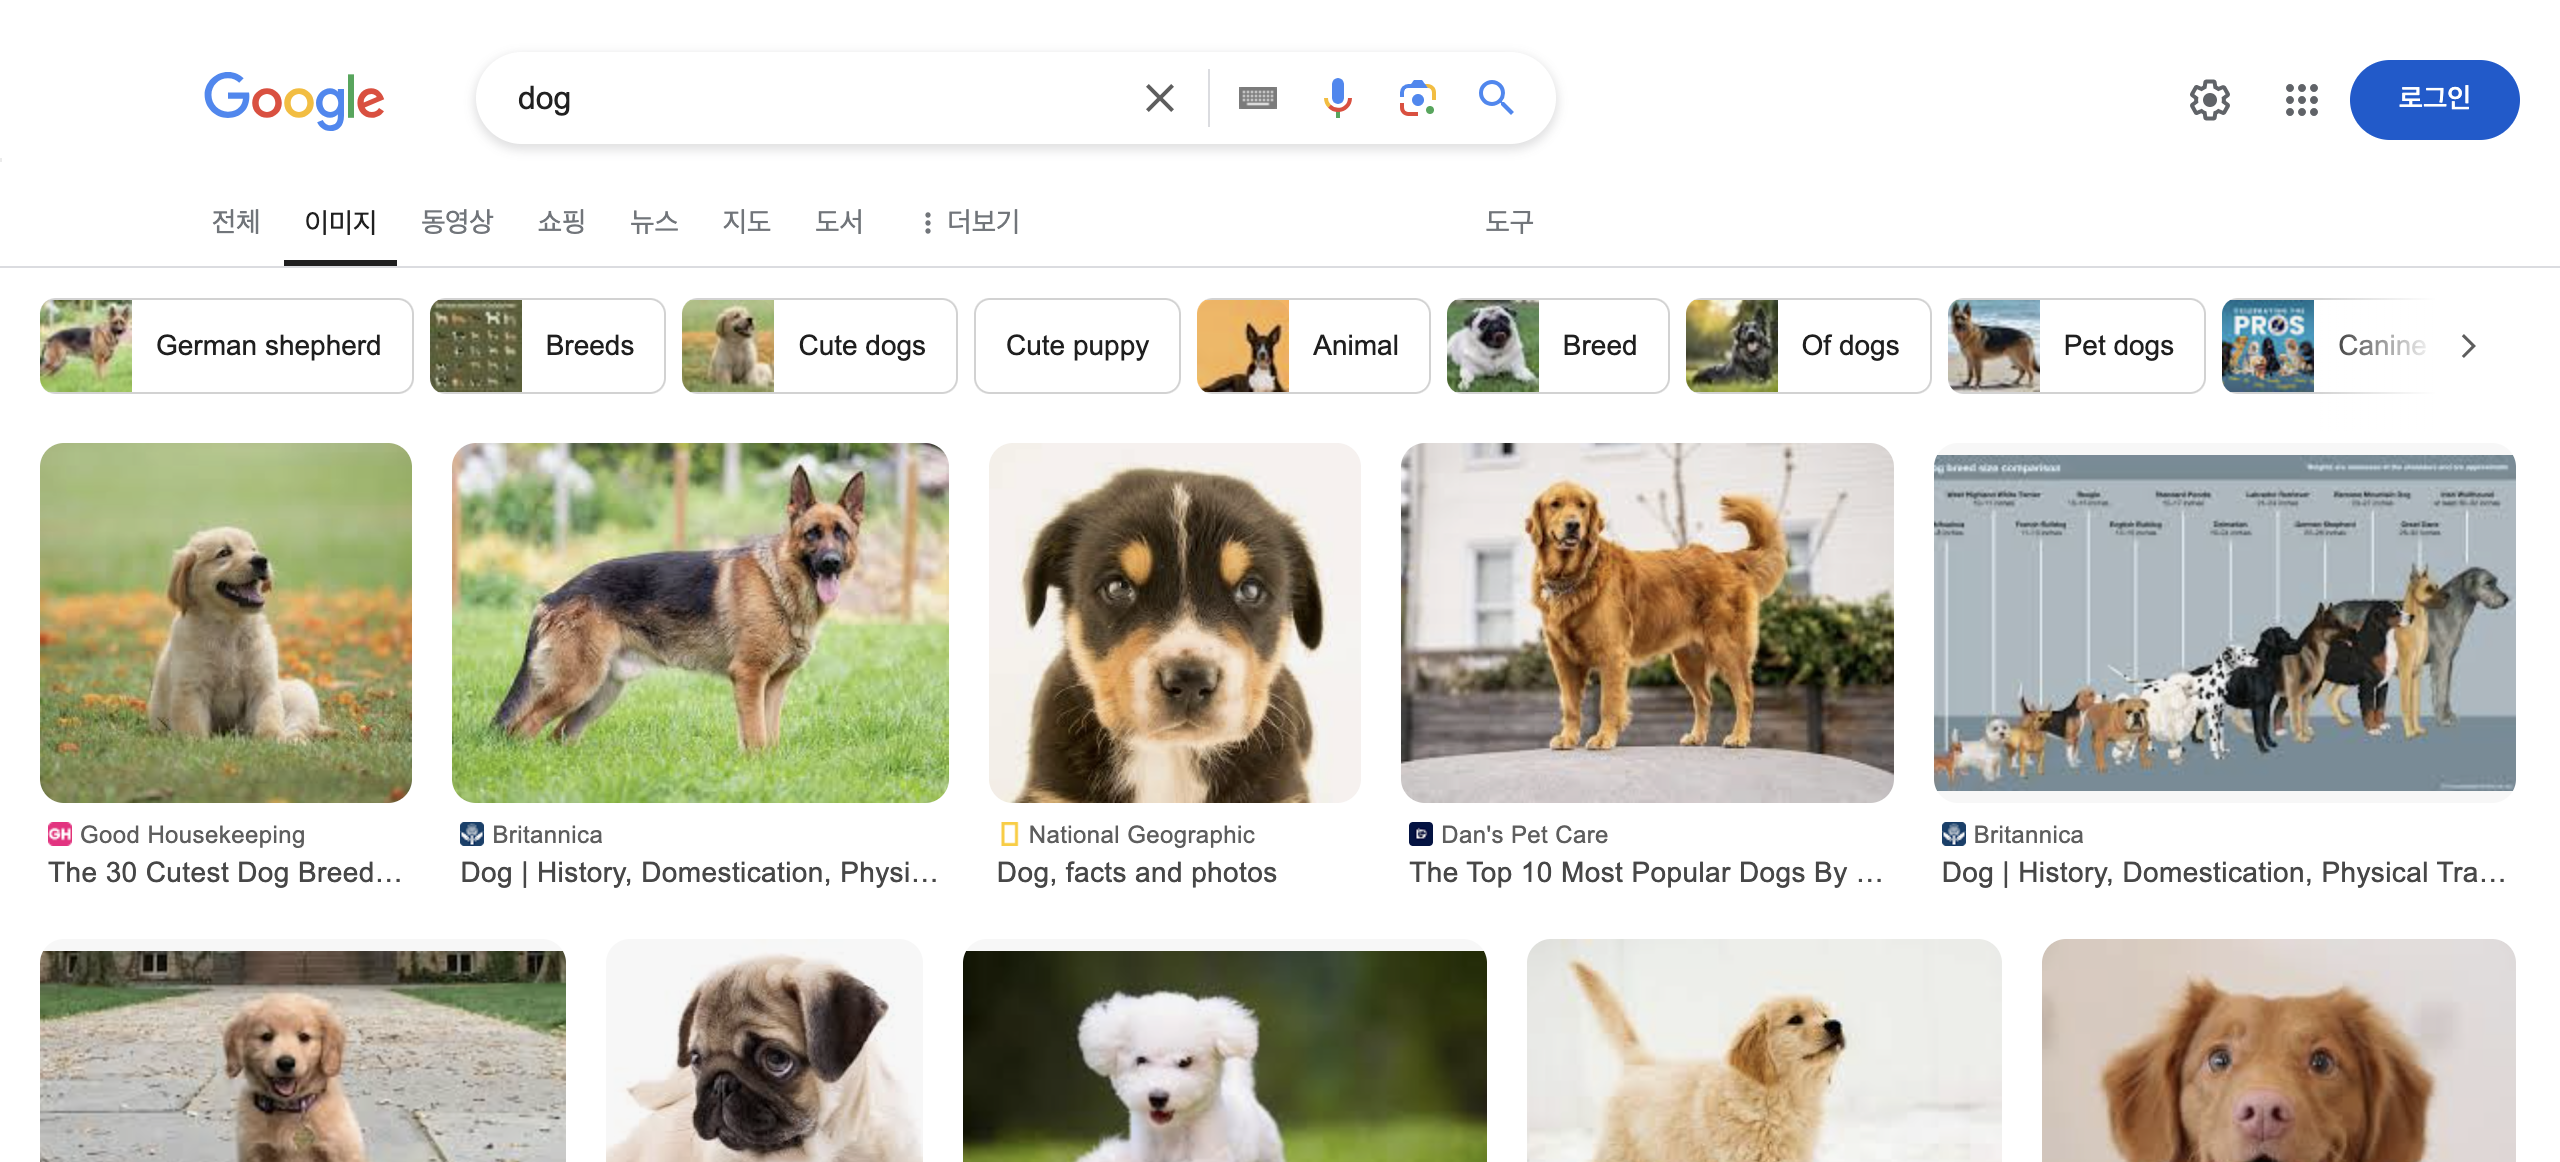

In [6]:
keyword = "dog"  # 이미지를 수집할 키워드

driver = setup_webdriver()  # 크롬 웹드라이버를 설정
driver.set_window_size(1280, 720)  # 스크린샷을 찍을 창 크기를 설정

access_google_image_search(driver, keyword)  # 구글 이미지 검색창에 접속


# 이미지를 로드합니다.
img = Image(driver.get_screenshot_as_png())
display(img)

In [7]:
def configure_image_search_options(driver):
    '''
    구글 이미지 검색창의 옵션을 설정하는 함수
    Args:
        driver (WebDriver): 크롬 웹드라이버
    '''
    ### 저작권 확인이 가능한 이미지만 검색합니다.
    # 이미지 검색창의 '도구' 버튼을 클릭합니다.
    # driver.find_elements(By.CSS_SELECTOR, '[jsname="bVqjv"]')[9].click()
    driver.find_element(By.ID, "hdtb-tls").click()
    print("도구 버튼 클릭 완료")

    # '사용권'을 클릭합니다.
    # driver.find_elements(By.CSS_SELECTOR, '[jsname="oYxtQd"]')[5].click()
    driver.find_elements(By.CLASS_NAME, 'AozSsc')[2].click()
    print("사용권한 버튼 클릭 완료")

    time.sleep(1.5)
    # '크리에이티브 커먼즈 라이선스'를 클릭합니다.
    # driver.find_elements(By.CSS_SELECTOR, '[jsname="NNJLud"]')[1].click()
    creative_commons_option = driver.find_element(By.XPATH, "//a[contains(text(), '크리에이티브 커먼즈 라이선스')]")
    driver.execute_script("arguments[0].click();", creative_commons_option)

    print('저작권 필터링 완료')

이미지 검색창 접속 완료
검색어 입력 완료
도구 버튼 클릭 완료
사용권한 버튼 클릭 완료
저작권 필터링 완료


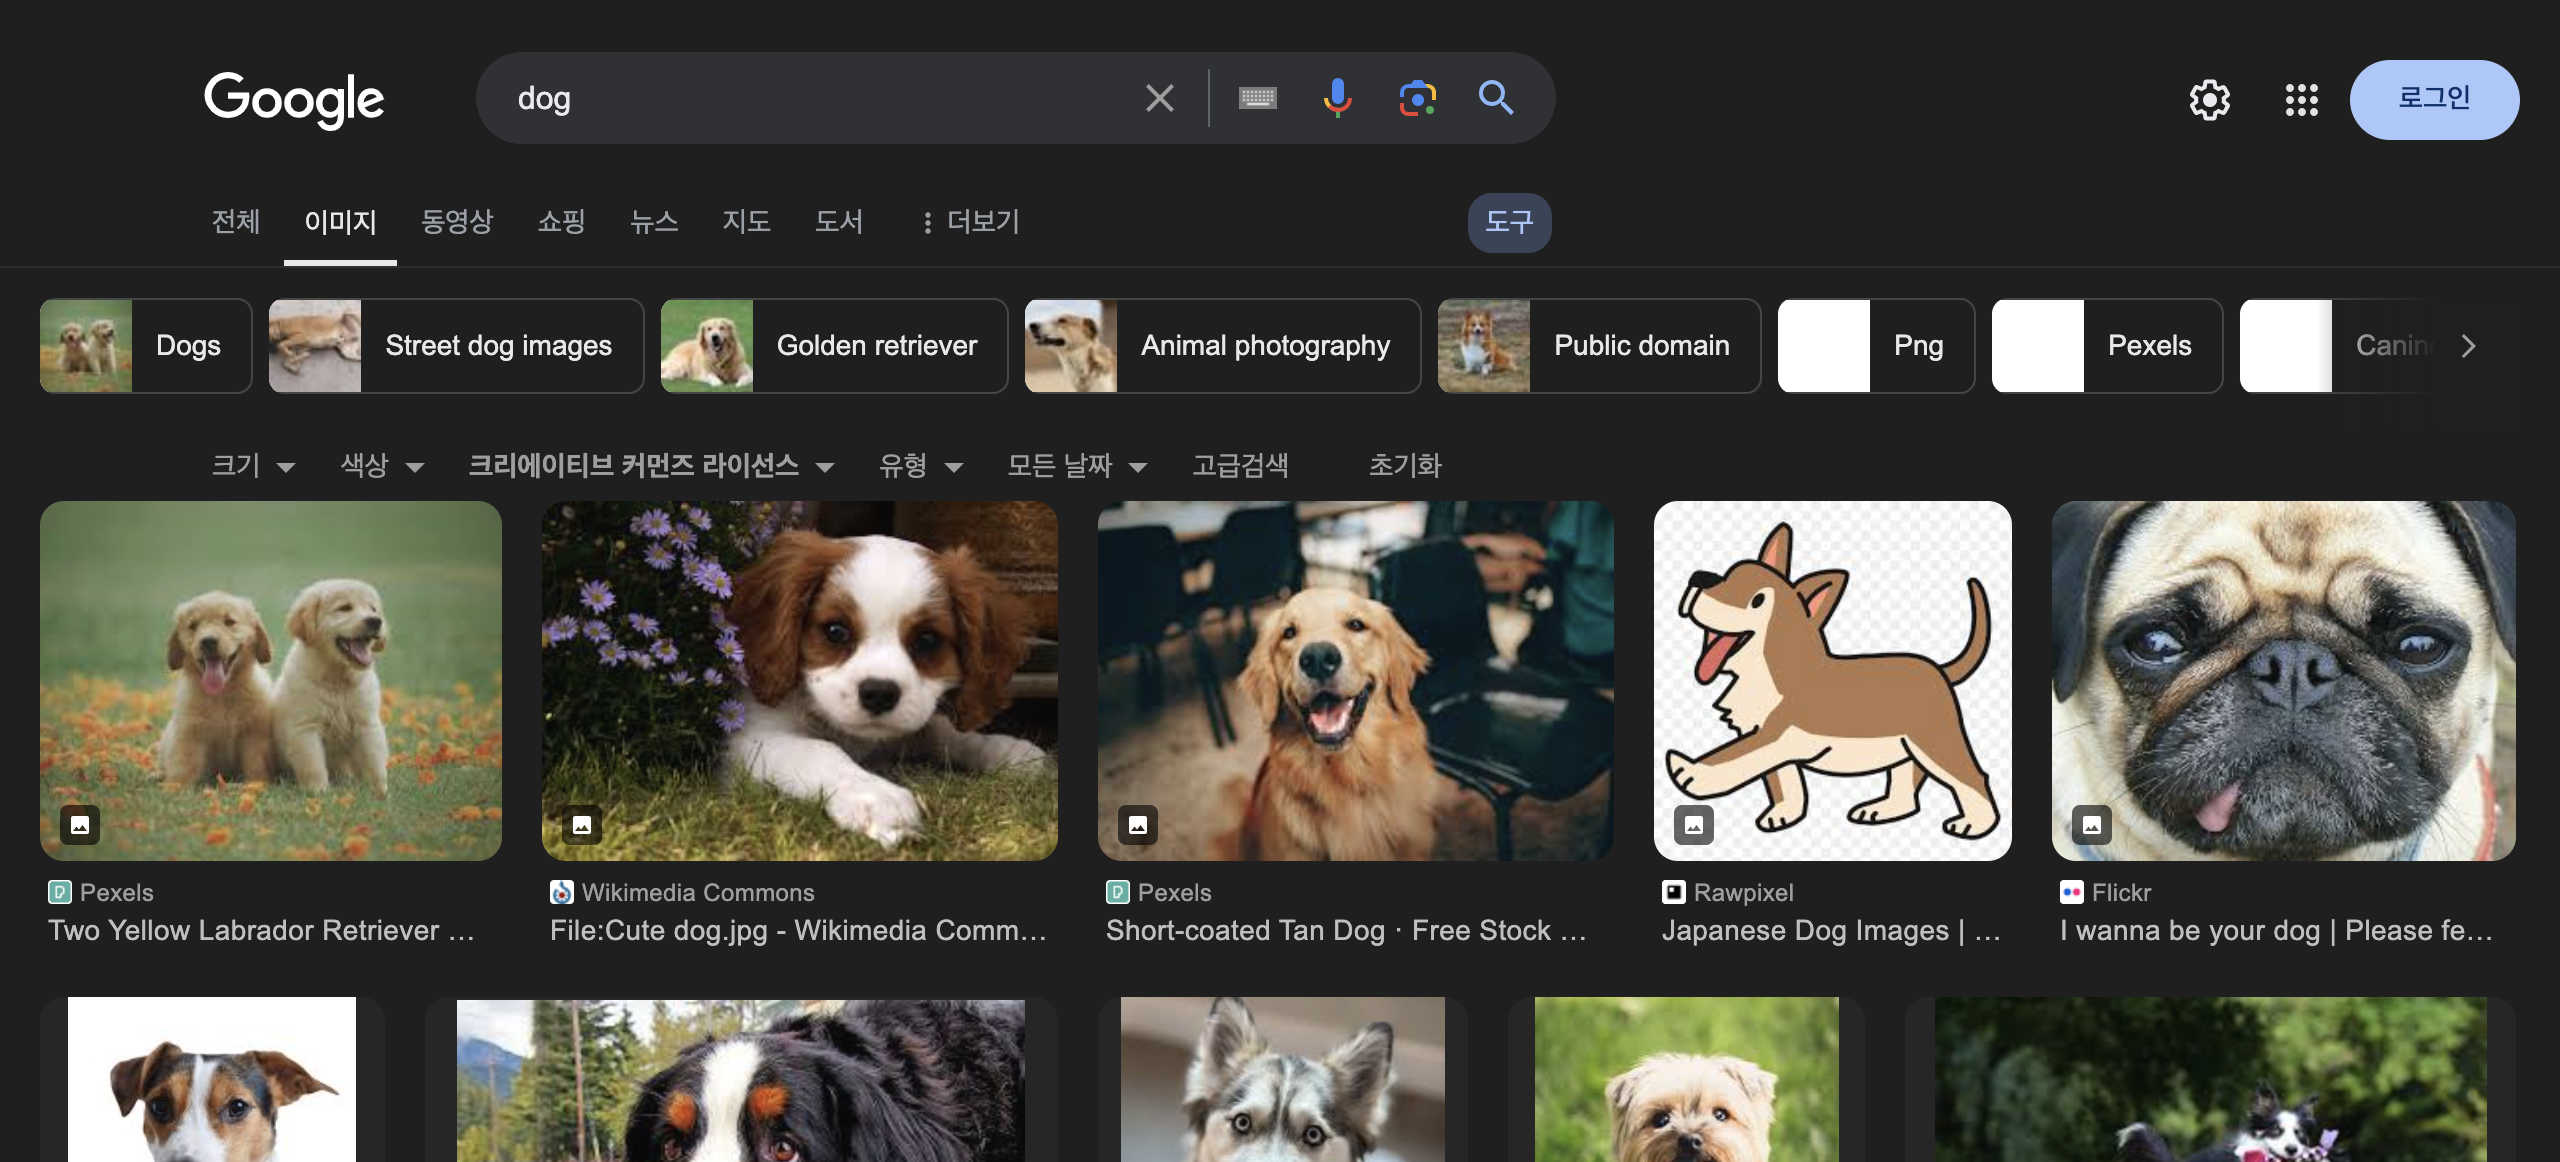

In [8]:
keyword = "dog"  # 이미지를 수집할 키워드

driver = setup_webdriver()  # 크롬 웹드라이버를 설정
driver.set_window_size(1280, 720)  # 스크린샷을 찍을 창 크기를 설정

access_google_image_search(driver, keyword)  # 구글 이미지 검색창에 접속
configure_image_search_options(driver)  # 구글 이미지 검색창의 옵션 설정


# 이미지를 로드합니다.
img = Image(driver.get_screenshot_as_png())
display(img)

In [9]:
def scroll_and_load_images(driver, num_images):
    '''
    스크롤을 내리면서 이미지를 로딩하는 함수
    Args:
        driver (WebDriver): 크롬 웹드라이버
        num_images (int): 이미지를 수집할 개수
    '''
    # num_images의 10%를 더 크롤링하도록 합니다.
    max_index = int(num_images*1.1) - 1

    # 스크롤을 0.5초마다 내리면서 이미지를 계속 로딩합니다.
    body = driver.find_element(By.CSS_SELECTOR, 'body')
    while True:
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.5)
        # 이미지들 중 max_index에 해당하는 이미지가 로딩되면 반복문을 종료합니다.
        if len(driver.find_elements(By.CSS_SELECTOR, f'[data-ri="{max_index}"]')) > 0:
            break
    print('이미지 리스트 로딩 완료')

In [10]:
def load_image_metadata(driver):
    '''
    이미지의 메타데이터를 가져오는 함수
    Args:
        driver (WebDriver): 크롬 웹드라이버
    Returns:
        img_src (str): 이미지의 src URL. 향후 이미지를 다운로드할 때 사용
        meta (dict): 이미지의 메타데이터
    '''
    # 이미지 소스를 가져옵니다.
    # 만일 아래의 코드에서 element를 찾을 수 없다는 에러가 발생한다면 scroll_and_load_images()의 타임슬립 시간을 늘립니다.
    img = driver.find_element(By.XPATH, '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]')
    img_src = img.get_attribute('src')
    img_alt = img.get_attribute('alt')

    # 이미지의 출처 및 저작권 정보를 가져옵니다.
    meta_list = driver.find_elements(By.CSS_SELECTOR, f'[jsname="CGzTgf"] .zTfuXc.cS4Vcb-pGL6qe-ysgGef a')

    # 이미지에 대한 설명, 출처, 웹사이트의 주소, 저작권 주소를 저장합니다.
    if len(meta_list) == 3:
        meta = {
            'description' : img_alt,
            'source' : meta_list[0].text,
            'source_url' : meta_list[0].get_attribute('href'),
            'copyright_url' : meta_list[1].get_attribute('href'),
        }
    # 이미지에 대한 설명, 웹사이트의 주소, 저작권 주소를 저장합니다.
    elif len(meta_list) == 2:
        meta = {
            'description' : img_alt,
            'source_url' : img_src,
            'copyright_url' : meta_list[0].get_attribute('href'),
        }
    # 혹여나 둘 다 없을 경우, 이미지 하단의 제목에 대한 하이퍼링크 URL을 가져옵니다.
    # 이 경우 이미지의 저작권 정보를 가져올 수 없으므로, 원칙적으로는 사용하지 않는 것이 바람직합니다.
    else:
        origin = driver.find_element(By.XPATH, '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[5]/div[1]/a[1]').get_attribute('href')
        meta = {
            'description' : img_alt,
            'source_url' : origin,
        }
    return img_src, meta

In [12]:
def save_image_metadata(img_src, meta, save_dir, i):
    '''
    이미지의 메타데이터를 json 파일로 저장하는 함수
    Args:
        meta (dict): 이미지의 메타데이터
        source (str): 이미지를 수집한 사이트의 이름
        keyword (str): 이미지를 수집한 키워드
        i (int): 이미지의 인덱스
    '''
    # 이미지의 URL이 data:image로 시작하는 경우, base64로 인코딩된 이미지 데이터입니다.
    # 따라서 이 경우에만 이미지 파일의 명칭을 'data_image'로 지정합니다.
    # 나머지 경우에는 이미지의 URL에서 파일명을 그대로 가져옵니다.
    meta_fname = 'data_image' if img_src[:10] == 'data:image' \
                 else img_src.split("/")[-1].split(".")[0]
    with open(os.path.join(save_dir, f'{i:02d}-{meta_fname}.json'), 'w', encoding='utf-8') as f:
        json.dump(meta, f, indent="\t", ensure_ascii=False)

In [13]:
def download_image(img_src, save_dir, i):
    '''
    이미지를 다운로드하는 함수
    Args:
        img_src (str): 이미지의 src URL
        keyword (str): 이미지를 수집한 키워드
        i (int): 이미지의 인덱스
    '''
    if img_src[:10] == 'data:image':
        # data:image로 시작하는 경우, base64로 인코딩된 이미지 데이터입니다.
        # base64로 인코딩된 데이터는 다음과 같은 형식으로 디코딩할 수 있습니다.
        # data:image/jpg;base64,XXXXXXXXXXXX
        # XXXXXXXX를 디코딩하면 이미지 데이터가 나옵니다.
        img_format, img_data = img_src.split(',')[0].split('/')[1].split(';')[0], img_src.split(',')[1]
        img_data = img_data.encode('utf-8')
        with open(os.path.join(save_dir, f'{i:02d}-data_image.{img_format}'), 'wb') as f:
            f.write(base64.decodebytes(img_data))
    else:
        # requests를 통해 이미지를 다운로드합니다.
        res = requests.get(img_src)
        time.sleep(3)
        with open(os.path.join(save_dir, f'{i:02d}-{img_src.split("/")[-1].split("?")[0]}'), 'wb') as f:
            f.write(res.content)

In [14]:
def crawl_and_save_image(driver, save_dir, i):
    '''
    이미지를 크롤링하고 저장하는 함수
    Args:
        driver (WebDriver): 크롬 웹드라이버
        keyword (str): 이미지를 수집할 키워드
        i (int): 이미지의 인덱스
    Returns:
        bool: 이미지를 성공적으로 크롤링했는지 여부
    '''
    # '관련 검색어' 아이템은 배제합니다.
    if len(driver.find_elements(By.CSS_SELECTOR, f'[data-ri="{i}"]:has(h2)')) > 0:
        print(f'{i+1:2d}번째 항목 스킵')
        return False

    # i번째 이미지를 클릭합니다.
    driver.find_elements(By.CSS_SELECTOR, f'[data-ri="{i}"]')[0].click()
    # 이미지가 로딩될 때까지 3초 기다립니다.
    time.sleep(3)
    print(f'{i+1:2d}번째 이미지 로딩 완료')

    # 이미지의 메타데이터를 가져옵니다.
    img_src, meta = load_image_metadata(driver)
    # 이미지의 메타데이터를 json 파일로 저장합니다.
    save_image_metadata(img_src, meta, save_dir, i)
    # 이미지를 다운로드합니다.
    download_image(img_src, save_dir, i)
    print(f'{i+1:2d}번째 이미지 저장 완료')
    return True

In [16]:
def setup_webdriver():
    '''
    크롤링에 필요한 웹드라이버를 설정하는 함수
    Returns:
        driver (WebDriver): 크롬 웹드라이버
    '''
    # colab에서 사용할 경우
    options = webdriver.ChromeOptions()
    # options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)

    # # 로컬에서 사용할 경우
    # # 위의 colab 관련 코드를 주석처리하고 아래의 코드를 주석해제해주세요.
    # # driver_path에 미리 다운로드 받은 크롬드라이버의 경로를 입력해주세요.
    # driver_path = '/Users/USER/Downloads/chromedriver'
    # driver = webdriver.Chrome(driver_path)

    return driver

In [17]:
data_dir = "./data"  # 이미지를 저장할 폴더의 상위 경로
# data_dir = "/content/drive/MyDrive/..."  # 구글 드라이브를 마운트한 경우
source_name = "Google"  # 이미지를 수집할 사이트의 이름
keyword = "cat"  # 이미지를 수집할 키워드
num_images = 10  # 이미지를 수집할 개수
count_images = 0  # 이미지를 크롤링한 개수

create_folders(data_dir, source_name, keyword)  # 이미지를 저장할 폴더 생성
driver = setup_webdriver()  # 크롬 웹드라이버를 설정

access_google_image_search(driver, keyword)  # 구글 이미지 검색창에 접속
configure_image_search_options(driver)  # 구글 이미지 검색창의 옵션 설정
scroll_and_load_images(driver, num_images)  # 스크롤을 내리면서 이미지 로딩

i = 0
pbar = tqdm(total=num_images)  # progress bar 생성
while count_images < num_images:
    is_crawled = crawl_and_save_image(driver, os.path.join(data_dir, keyword, source_name), i)
    i += 1
    if is_crawled :  # 크롤링에 성공할 경우
        count_images += 1  # 크롤링한 이미지 수 1 증가
        pbar.update(1)  # progress bar 1 증가
driver.quit()  # 크롬 웹드라이버 종료

이미지 검색창 접속 완료
검색어 입력 완료
도구 버튼 클릭 완료
사용권한 버튼 클릭 완료
저작권 필터링 완료


KeyboardInterrupt: 